# Metropolis-Hastings algorithm

In this notebook, I will implement Metropolis-Hastings algorithm, a popular example of Markov Chain Monte Carlo sampling method.

In [1]:
import random 
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1. Theory

### 1.1 Notation

Let us define notations as follows: 
* $X$ : a set (or more precisely, a measurable space with an appropriate sigma algebra), on which we consider probability distribution 
* $p(x) = \tilde{p}(x)/Z_p$ : the density function of the distribution from which we want to sample, where the constant $Z_p$ can be unknown.
* $q(x|x')$ : proporsal kernel, where $q(x|x')$ stands for the probability density of getting $x$ as a candidate conditioned on we have $x'$ now. 

### 1.2 Algorithm
* input : the initial point $x^{ini} \in X$, the number of samples required $N$
* output : the sequence of variables $x^{(1)}, x^{(2)}, \dots x^{(N)}$, which (approximately) obey the distribution $p$.
* Given $x^{(t)}$, generate $x^{tmp}$ according to $q(\cdot | x^{(t)})$. 
* Set 

$$
\begin{align}
    x^{(t+1)} = 
    \begin{cases}
        x^{tmp} & (\mbox{with probability } A(x^{tmp}, x^{(t)})) \\ 
        x^{(t)} & (\mbox{with probability } 1 - A(x^{tmp}, x^{(t)}))
    \end{cases},
\end{align}
$$

where

$$
\begin{align}
    A(x,y) := \min\left( 1, \ \frac{\tilde{p}(x)}{\tilde{p}(y)}\cdot \frac{q(y|x)}{q(x|y)} \right)
\end{align}
$$


## 2. Code

Here, 
* we assume $X$ to be $D$ dimensional Euclidean space, and 
* use a $D$ dimensional gaussian distribution with a given covariance matrix $\Sigma$ as the proporsal kernel : 

$$
\begin{align}
    q(x|y) = \frac{1}{(2\pi)^{D/2} \sqrt{\det \Sigma}} \exp\left[ -\frac{1}{2}(x-y)^T \Sigma^{-1} (x-y) \right]
\end{align}
$$


In [2]:
class MHsampler:
    def __init__(self, dim, q_cov, p):
        # the dimension of the output space
        self.dim = dim
        
        # the covariance matrix of the proporsal kernel
        self.sigma = q_cov
        # the precision matrix of the proporsal kernel
        # note that np.linalg.inv does not accommodate the case with dim = 1
        if self.dim == 1:
            self.lam = 1.0/q_cov
        else:
            self.lam = np.linalg.inv(self.sigma)
        
        # the density function of the target distribution
        self.p = p
    
    def q(self,x,y):
        tmp = (x-y) @ self.lam @ (x-y)
        return np.exp(-0.5*tmp)
    
    def A(self,x,y):
        denom = self.p(y)*self.q(x,y)
        if denom == 0:
            return 1.0
        else:
            return min( 1, self.p(x)*self.q(y,x)/denom )
    
    def sample(self, xini, N):
        # array for recording the sample
        self.X = np.zeros((N, self.dim))
        # array for storing whether the candidate is accepted or not
        self.accept = np.ones(N)
        # array for storing rejected candidates
        self.cand = np.zeros((N, self.dim))
        x = xini
        for i in range(N):
            # sample from the proporsal kernel (gaussian )
            xtmp = np.random.multivariate_normal(x, self.sigma)
            tmprand = random.random()
            if tmprand < self.A(xtmp,x):
                x = xtmp
            else:
                self.accept[i] = 0.0
                self.cand[i] = xtmp
            self.X[i] = x
        return self.X

## 3. Experiments

We consider two exmples
* gamma distribution (one dimensional)
* two dimensional gaussian distribution

### 3.1 Gamma distribution (1-D)

$$
\begin{align}
    & p(x) = \frac{1}{\Gamma(k) \theta^k} x^{k-1} e^{-\frac{x}{\theta}} \\
    & \mbox{mean} : k \theta \\
    & \mbox{variance} : k \theta^2
\end{align}
$$


In [3]:
def pgam(x):
    if x > 0:
        return (x**2)*np.exp(-x)
    else:
        return 0.0

sampler = MHsampler(dim = 1, q_cov = np.array([[1.0]]), p = pgam)
X = sampler.sample(np.array([1.0]), 20000)[:,0]

sample mean : 3.0327031300258476
sample variance : 3.1273912037762597


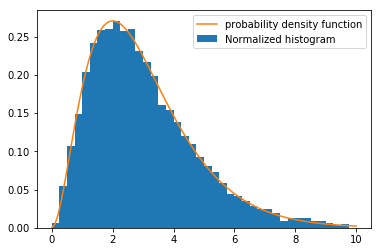

In [4]:
print(f"sample mean : {np.mean(X)}")
print(f"sample variance : {np.var(X)}")
step = 0.25
plt.hist(X,bins=np.arange(0,10,step), normed=True, label="Normalized histogram")
xx = np.linspace(0,10,100)
plt.plot(xx, 0.5*xx**2*np.exp(-xx), label="probability density function")
plt.legend()
plt.show()

### 3.2 Two-dimensional normal distribution

$$
\begin{align}
    & p(x) = \frac{1}{2 \pi \sqrt{\det \Sigma}} \exp\left( -\frac{1}{2} x^T \Sigma^{-1} x \right)  \\
    & \Sigma^{-1} = \begin{pmatrix}
    10 & -6  \\
    -6 & 10
    \end{pmatrix} \\
    & \Sigma = 
    \frac{1}{32}
    \begin{pmatrix}
    5 & 3  \\
    3 & 5
    \end{pmatrix}
    = \begin{pmatrix}
    0.15625 & 0.09375  \\
    0.09375 & 0.15625
    \end{pmatrix}
\end{align}
$$


In [5]:
def p(x):
    precmat = np.array([[10,-6],[-6,10]])
    return np.exp(-0.5*x @ precmat @ x)

sampler = MHsampler(dim = 2, q_cov = np.array([[1,0],[0,1]]), p = p)
X = sampler.sample(np.array([1,0]), 30000)

sample mean : [-0.00924147 -0.00391578]
sample covariance : [[ 0.16210739  0.10049358]
 [ 0.10049358  0.16742724]]


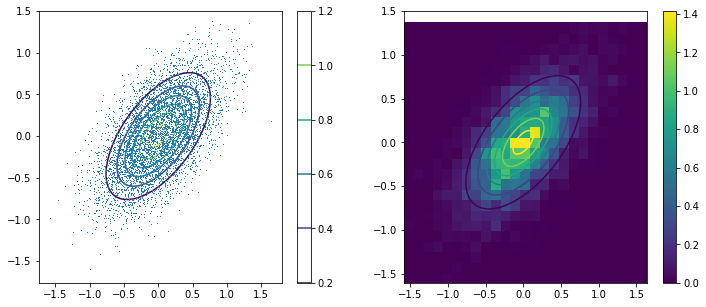

In [6]:
print(f"sample mean : {np.mean(X,axis=0)}")
print(f"sample covariance : {np.cov(X, rowvar=False)}")

# two dimensional histogram
H, xx, yy = np.histogram2d(X[:,0], X[:,1], bins=25, normed=True)
H = H.T
XX, YY = np.meshgrid(xx, yy)

# contour plot of the density function
xx_f = np.linspace(-1.5,1.5,100)
yy_f = np.linspace(-1.5,1.5,101)
XX_f, YY_f = np.meshgrid(xx_f, yy_f)
Z_f = np.exp( -0.5*( 10*XX_f*XX_f -12*XX_f*YY_f + 10*YY_f*YY_f ))/(2*np.pi)*8

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(X[:,0], X[:,1],',')
plt.contour(XX_f,YY_f,Z_f)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(XX, YY, H)
plt.colorbar()
plt.contour(XX_f,YY_f,Z_f)
plt.show()